# 05.2 - SGD Optimiser (With Momentum)

In this section, we look at how an SGD Optimiser with momentum behaves, particularly in comparison to NAG. This was not initially part of our plan, but given the little details and discrepancies that we came across with TensorFlow documentation in section 05.1, we decided to take a look at this briefly, as this should be akin to Classical Momentum described in the Sutskever et al. 2013 paper (references made in previous section).

We expect this optimiser to behave very similarly to what we saw for NAG in the previous section, but we more so want to see if this is exactly the same to identify whether the TensorFlow documentation print was a mistake, or whether the implementation is truly different. This does step outside of the scope of the report by a bit but we felt that it would provide meaningful comparison and further understanding and interpretability.

In [1]:
import time
import json

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import KLDivergence

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

#### Load Data

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Training

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers 
    for i in hidden_nodes:
        #we use 'relu' as good, safe default for our neural nets
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

 

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', 
             c_metrics = ['accuracy',TruePositives(),tfa.metrics.CohenKappa(num_classes=5)]):
    
    '''
    Function that takes dataframe train_df and creates a multiclass classifer neural network 
    with softmax output layers equal to the number of classes passed
    
    train_df = dataframe or array 
    num_classes = int, number of classes in the dataset
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final 
                   output layer containing num_classes softmax nodes
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    c_metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    #we initiate our model differently here, taking layers as a list
    #this is because of some issues when implementing when creating a neural net as above
    layers = []
    #input dimensions
    layers.append(Input(shape = (train_df.shape[1],)))
    
    #add layers with dropout
    for i in hidden_nodes:
        layers.append(Dense(i, activation = 'relu'))
        layers.append(Dropout(0.2))
        
    #output layer with number of nodes = num_classes
    layers.append(Dense(num_classes, activation = 'softmax'))
    
    nn_model = Sequential(layers)
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=c_metrics)
    
    return nn_model

In [5]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [6]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

Train binary and multiclass models for SGD, SGD, and SGD.

In [8]:
#Jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

#verbose variable
v = 0

count = 1
#number of times our model parses through the entire data it is given
epochs = 30
#number of data points the model goes through before updating next weight
batch_size = 500
start = time.time()

for eps in epsilons:
    #assign optimiser. Some are commented out and then used in other notebooks
    sgd_mom_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                          momentum = 0.9,
                                          nesterov = False)

    # nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
    #                                   momentum = 0.9, 
    #                                   nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #this originally fit same model architecture for each optimizer ['sgd','nag','adam']
    #the list iteration format was kept because iterating over 1 variable does change runtime, realistically
    #we also wanted to demonstrate the code style were we to not face memory issues
    for opt in ['sgd_mom']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #nicer preview/output readability
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #record model history fitting to binary training data with validation split
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = v)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        #nice print
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #fit model
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = v)
        #assign model and history to variables
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
    #delete temp model and history to free up memory
    del bin_model_temp
    del bin_history_temp
    del categ_model_temp
    del categ_history_temp
    print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to sgd_mom optimizer with learning rate 0.1----------
----------Fitting categorical model to sgd_mom optimizer with learning rate 0.1----------

----------Fitting binary model to sgd_mom optimizer with learning rate 0.01----------
----------Fitting categorical model to sgd_mom optimizer with learning rate 0.01----------

----------Fitting binary model to sgd_mom optimizer with learning rate 0.001----------
----------Fitting categorical model to sgd_mom optimizer with learning rate 0.001----------

----------Fitting binary model to sgd_mom optimizer with learning rate 0.0001----------
----------Fitting categorical model to sgd_mom optimizer with learning rate 0.0001----------



In [9]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  992.491866 seconds


### Save Models and Histories

We save the models and the histories created so that they can be reloaded easily if we need to do further analysis or revisit anything at a later point without running all the models again. 

Run these anyway even if you do not intend to stop and return to them, as this affects how the model histories are called later.

In [10]:
#create a folder called saved_models and one called saved_hists to prevent saving errors
!mkdir saved_models saved_hists

#since epsilons[0] corresponds to model_1 and epsilons[3] correponds to model_4 we use range(1, len(epsilons) + 1)
for i in range(1,len(epsilons)+1):
    
    #assign name to variable for better code readability later
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    #save the binary and category models in saved_models folder
    locals()[bin_name].save('saved_models/{}'.format(bin_name))
    locals()[categ_name].save('saved_models/{}'.format(categ_name))

    #as above, for histories
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    #call .history and dump using json
    json.dump(locals()[bin_hist].history, open('saved_hists/{}'.format(bin_hist), 'w'))
    json.dump(locals()[categ_hist].history, open('saved_hists/{}'.format(categ_hist), 'w'))    

A subdirectory or file saved_models already exists.
Error occurred while processing: saved_models.
A subdirectory or file saved_hists already exists.
Error occurred while processing: saved_hists.


INFO:tensorflow:Assets written to: saved_models/sgd_mom_bin_model_1\assets
INFO:tensorflow:Assets written to: saved_models/sgd_mom_categ_model_1\assets
INFO:tensorflow:Assets written to: saved_models/sgd_mom_bin_model_2\assets
INFO:tensorflow:Assets written to: saved_models/sgd_mom_categ_model_2\assets
INFO:tensorflow:Assets written to: saved_models/sgd_mom_bin_model_3\assets
INFO:tensorflow:Assets written to: saved_models/sgd_mom_categ_model_3\assets
INFO:tensorflow:Assets written to: saved_models/sgd_mom_bin_model_4\assets
INFO:tensorflow:Assets written to: saved_models/sgd_mom_categ_model_4\assets


## Load Models and Histories

Now to load the data that we just saved.

In [4]:
#change this opt varfor each optimiser later
opt = 'sgd_mom'
#reassign same epsilons in case you do not want to run from above
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

#load as with the saving above
for i in range(1,len(epsilons)+1):
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    
    locals()[bin_name] = tf.keras.models.load_model('saved_models/{}'.format(bin_name))
    locals()[categ_name] = tf.keras.models.load_model('saved_models/{}'.format(categ_name))
    
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    
    locals()[bin_hist] = json.load(open('saved_hists/{}'.format(bin_hist), 'r'))
    locals()[categ_hist] = json.load(open('saved_hists/{}'.format(categ_hist), 'r'))

In [5]:
#load for nag
opt2 = 'nag'

#load as with the saving above
for i in range(1,len(epsilons)+1):
    bin_name = '{}_bin_model_{}'.format(opt2,i)
    categ_name = '{}_categ_model_{}'.format(opt2,i)
    
    locals()[bin_name] = tf.keras.models.load_model('saved_models/{}'.format(bin_name))
    locals()[categ_name] = tf.keras.models.load_model('saved_models/{}'.format(categ_name))
    
    bin_hist = '{}_bin_history_{}'.format(opt2,i)
    categ_hist = '{}_categ_history_{}'.format(opt2,i)
    
    locals()[bin_hist] = json.load(open('saved_hists/{}'.format(bin_hist), 'r'))
    locals()[categ_hist] = json.load(open('saved_hists/{}'.format(categ_hist), 'r'))

## Plots and Assessing Performance

We won't make as many specific comments in this section as we did in the previous ones, and we will focus mainly on comparing to our NAG optimiser

### Binary Model

**Binary Cross Entropy Loss**<br>
We with binary cross entropy

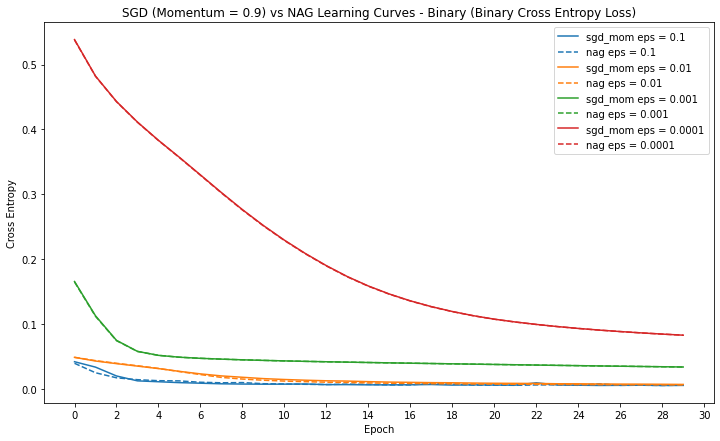

In [7]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

clrs = ['C0','C1','C2','C3']

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_bin_history_{}'.format(opt2,count)]['val_loss'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

The similarity here is resounding. At first site, we might think that NAG and SGD Momentum are exactly the same optimisers. The small differences for learning rate 0.1 may or may not be insignificant as even with `tensorflow.random.set_seed(rseed)` being the same throughout, GPU parallelisation can still be random, so whether this is significant or not is hard to see here.

**AUC:**<br>
We look at AUC now to see if anything changes or not.

In [9]:
auc = list(sgd_mom_bin_history_1.keys())[-1]
nag_auc = list(nag_bin_history_1.keys())[-1]

auc,nag_auc

('val_auc', 'val_auc_1')

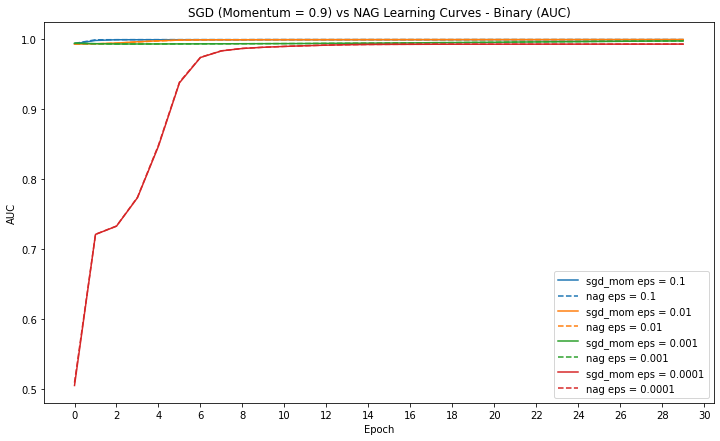

In [10]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_bin_history_{}'.format(opt2,count)][nag_auc],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))
    
plt.legend()
plt.show()

Again, the results are almost identical. Not much to say here, so we explore the multiclass scenario to see if that changes anything. We examine the top 3 learning rates just in case.

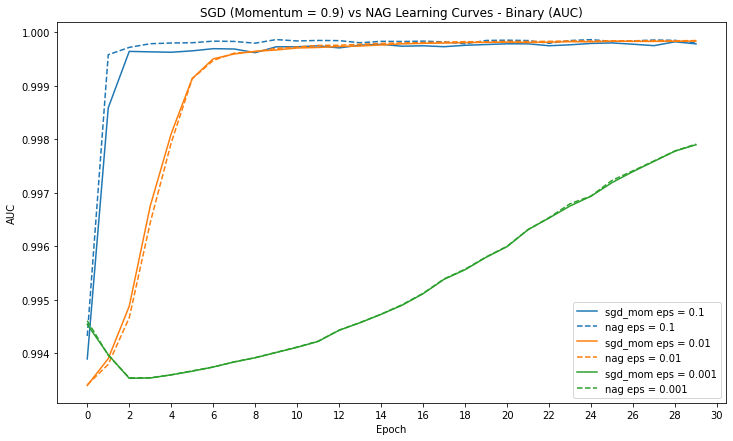

In [11]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


clrs = ['C0','C1','C2','C3']

for count in range(1,len(epsilons)):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_bin_history_{}'.format(opt2,count)][nag_auc],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))
plt.legend()
plt.show()

Tiny differences, whether these are random are not remain difficult to identify.

**Confusion Matrix**<br>
We explore these for completeness, but do not expect to see anything different from above.

In [15]:
tf.random.set_seed(rseed)
sgd_mom_pred = sgd_mom_bin_model_1.predict(X_test)

In [16]:
sgd_mom_pred_bin = sgd_mom_pred
sgd_mom_pred_bin[sgd_mom_pred_bin>0.5]=1
sgd_mom_pred_bin[sgd_mom_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for SGD (Momentum = 0.9) with learning rate 0.1')

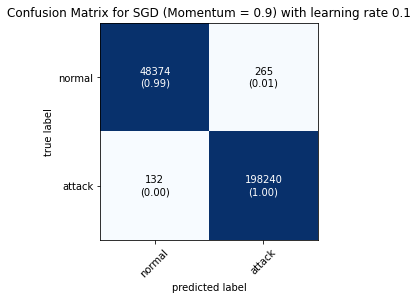

In [17]:
cmat_sgd_mom = confusion_matrix(y_test_bin,sgd_mom_pred)
cmat_sgd_mom

plot_confusion_matrix(
    conf_mat = cmat_sgd_mom,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for SGD (Momentum = 0.9) with learning rate {}'.format(epsilons[0]))

In [13]:
tf.random.set_seed(rseed)
nag_pred = nag_bin_model_1.predict(X_test)

In [14]:
nag_pred_bin = nag_pred
nag_pred_bin[nag_pred_bin>0.5]=1
nag_pred_bin[nag_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for NAG with learning rate 0.1')

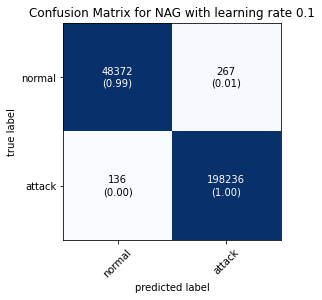

In [15]:
cmat_nag = confusion_matrix(y_test_bin,nag_pred)
cmat_nag

plot_confusion_matrix(
    conf_mat = cmat_nag,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for NAG with learning rate {}'.format(epsilons[0]))

Fairly identical performance, we move on to the categorical case.

## Categorical Model

We expect to see some changes here if there are to be any as this case is more 'difficult' for an optimiser to solve than the binary case and we hope that this would highlight any differences between the two optimisers, if any exist.

**Categorical Cross Entropy Loss:**<br>
We plot the cross entropy side by side

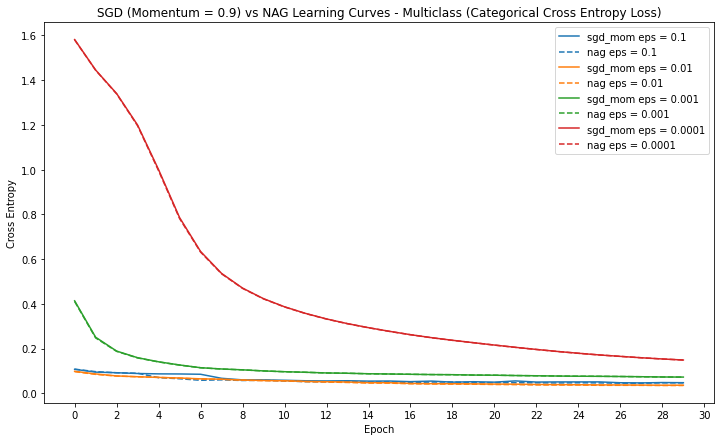

In [16]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_loss'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_categ_history_{}'.format(opt2,count)]['val_loss'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

Again, we have that loss behaviour behaves almost exactly the same for both optimisers across all learning rates. 

We continue exploring our other metrics in case the two optimisers are attaining similar loss values but converging to different minima (though this would be a huge coincidence).

**Categorical Accuracy:**<br>
Plotting categorical accuracy side by side

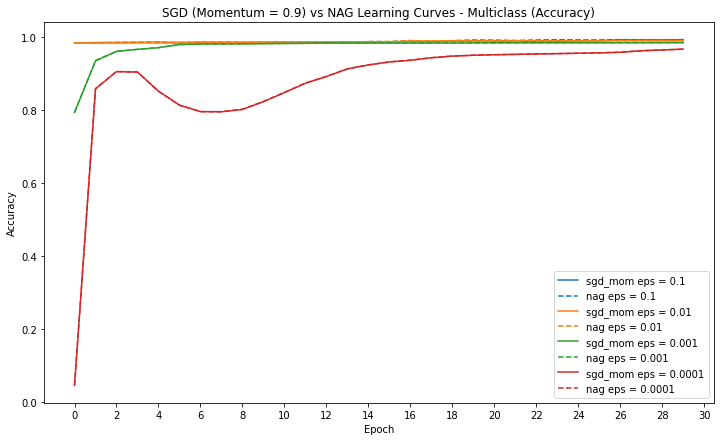

In [17]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_categ_history_{}'.format(opt2,count)]['val_accuracy'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

Plotting the larger epsilon values for accuracy, for easier comparison

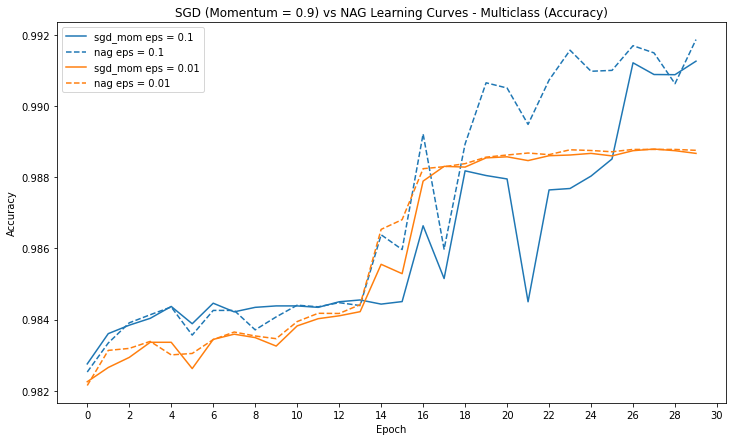

In [18]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_categ_history_{}'.format(opt2,count)]['val_accuracy'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

Model behaviour seems identical for learning rates of 0.01, 0.001, and 0.0001 but we see some differences in 0.1 where NAG performs better than SGD with momentum to some extent. However, the differences here are very miniscule and we can arguably treat them as the same, citing GPU parallelisation randomness as the reason why.

**Cohen-Kappa Score:**<br>
However, given our class imbalances, maybe accuracy is not the best to look at, so we once more plot Cohen-Kappa scores

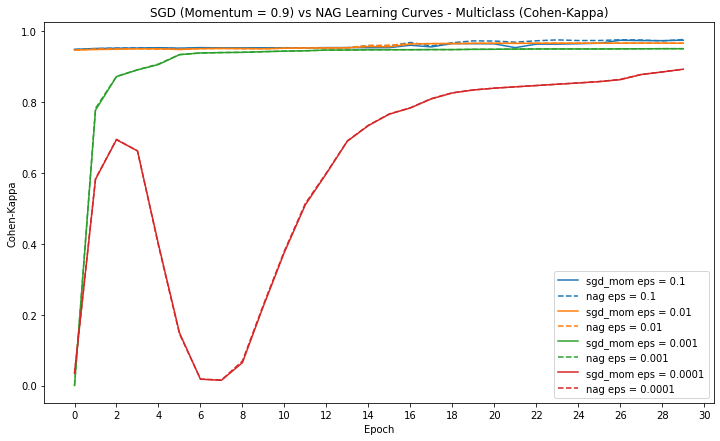

In [19]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_categ_history_{}'.format(opt2,count)]['val_cohen_kappa'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

Plotting for larger epsilons

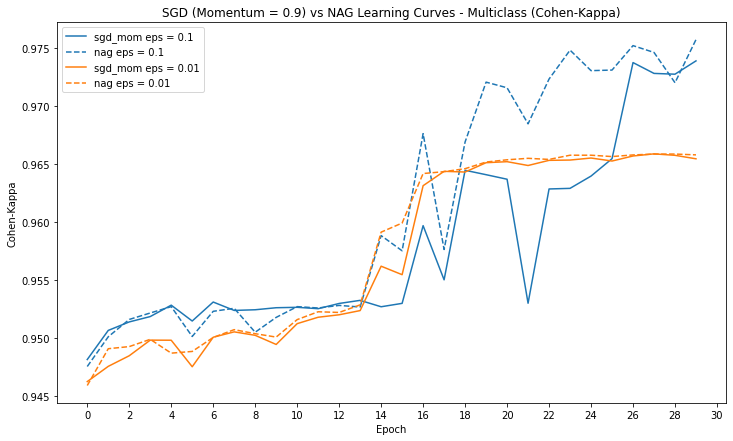

In [20]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD (Momentum = 0.9) vs NAG Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_categ_history_{}'.format(opt2,count)]['val_cohen_kappa'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

Accuracy and Cohen Kappa behave identically to one another to a large extent here, so thre is not much to comment on.

**Confusion Matrices**<br>
We could stop the comparisons here (and we hope that this has convinced the reader sufficiently that the two optimisers are largely similar), but we explore confusion matrices for completeness.

In [37]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['sgd_mom_categ_model_{}'.format(i+1)]
    sgd_mom_categ_pred = model.predict(X_test)
    locals()['sgd_mom_categ_pred_{}'.format(i+1)] = sgd_mom_categ_pred

In [38]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['nag_categ_model_{}'.format(i+1)]
    nag_categ_pred = model.predict(X_test)
    locals()['nag_categ_pred_{}'.format(i+1)] = nag_categ_pred

In [39]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

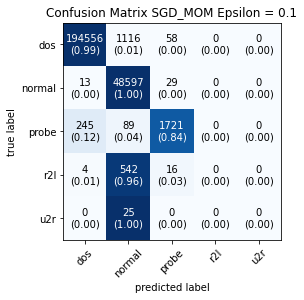

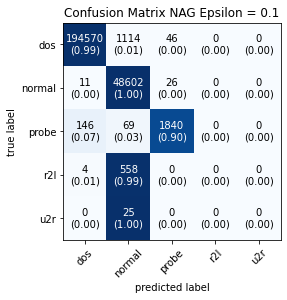

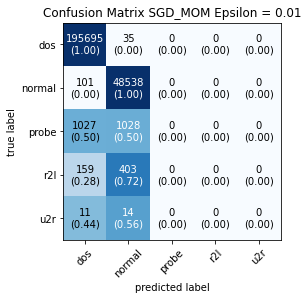

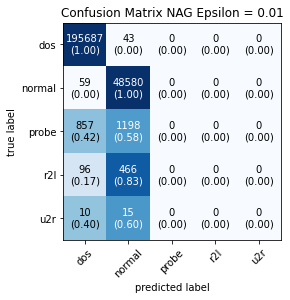

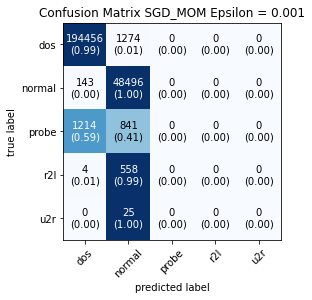

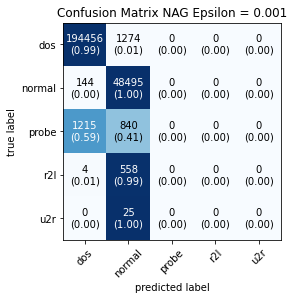

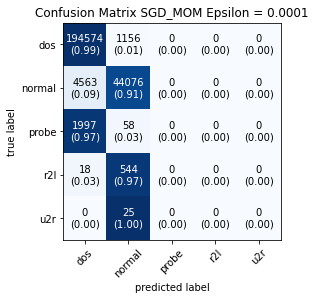

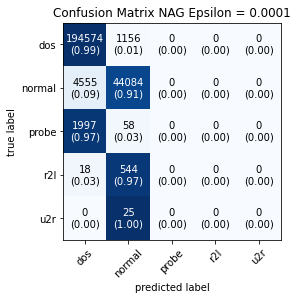

In [41]:
for i in range(len(epsilons)):
    sgd_mom_categ_pred = locals()['sgd_mom_categ_pred_{}'.format(i+1)]
    
    cmat_categ_sgd_mom = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(sgd_mom_categ_pred,axis=1))
    
    locals()['cmat_categ_sgd_mom_{}'.format(i)] = cmat_categ_sgd_mom
   
    
    plot_confusion_matrix(
        conf_mat = cmat_categ_sgd_mom,
        show_normed = True,
        class_names = categs
    )
    
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))
    
    nag_categ_pred = locals()['nag_categ_pred_{}'.format(i+1)]
    
    cmat_categ_nag = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(nag_categ_pred,axis=1))
    
    locals()['cmat_categ_nag_{}'.format(i)] = cmat_categ_nag
   
    
    plot_confusion_matrix(
        conf_mat = cmat_categ_nag,
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt2.upper(),epsilons[i]))
    
del sgd_mom_categ_pred
del nag_categ_pred

While a lot of these comparison probably were not necessarily, having eliminated that the loss functions converge to different minima, and we see th only noticable difference in the optimisers is seen at a learning rate of 0.1 where NAG arguably performs better by a small amount when it comes to categorising probe attacks.

When we had larger batch sizes and no dropout (and when we tried two different random seeds) we saw persistence of the same behaviour throughout. The reader is welcome to try this by simply changing the `rseed` value at the beginning of the respective notebooks and run everything again to see whether this holds or not. We were not able to recreate the results in time to then display and comment on properly given the time restraints.